In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load dataset
df = pd.read_csv("Data/Iris.csv")
df = df.drop("Id", axis=1)

# Map species to integers manually
species_map = {name: idx for idx, name in enumerate(df["Species"].unique())}
df["Species_encoded"] = df["Species"].map(species_map)

X = df.drop(["Species", "Species_encoded"], axis=1).values
y = df["Species_encoded"].values

df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [7]:
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.8 * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


In [20]:
import numpy as np
import pandas as pd

# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv("Data/Iris.csv")
df = df.drop("Id", axis=1)

# Map species to integers manually
species_map = {name: idx for idx, name in enumerate(df["Species"].unique())}
df["Species_encoded"] = df["Species"].map(species_map)

X = df.drop(["Species", "Species_encoded"], axis=1).values
y = df["Species_encoded"].values

# Train-test split (80-20)
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.8 * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# -------------------------------
# Linear Regression (Manual)
# -------------------------------
class LinearRegressionManual:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            y_pred = np.dot(X, self.weights) + self.bias
            error = y_pred - y

            dw = (2 / n_samples) * np.dot(X.T, error)
            db = (2 / n_samples) * np.sum(error)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# -------------------------------
# One-vs-Rest wrapper for multi-class
# -------------------------------
class OneVsRestLinearReg:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.models = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.models = []

        for cls in self.classes:
            y_binary = np.where(y == cls, 1, 0)  # One-vs-rest labels
            model = LinearRegressionManual(self.lr, self.epochs)
            model.fit(X, y_binary)
            self.models.append(model)

    def predict(self, X):
        preds = np.array([m.predict(X) for m in self.models])
        return self.classes[np.argmax(preds, axis=0)]


# -------------------------------
# F1 Score Computations
# -------------------------------
def precision_recall_f1(y_true, y_pred, cls):
    tp = np.sum((y_true == cls) & (y_pred == cls))
    fp = np.sum((y_true != cls) & (y_pred == cls))
    fn = np.sum((y_true == cls) & (y_pred != cls))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1, tp, fp, fn

def macro_f1(y_true, y_pred):
    classes = np.unique(y_true)
    f1s = []
    for cls in classes:
        _, _, f1, _, _, _ = precision_recall_f1(y_true, y_pred, cls)
        f1s.append(f1)
    return np.mean(f1s)

def micro_f1(y_true, y_pred):
    classes = np.unique(y_true)
    tp_total, fp_total, fn_total = 0, 0, 0
    for cls in classes:
        _, _, _, tp, fp, fn = precision_recall_f1(y_true, y_pred, cls)
        tp_total += tp
        fp_total += fp
        fn_total += fn
    precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
    recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

def weighted_f1(y_true, y_pred):
    classes = np.unique(y_true)
    total = len(y_true)
    f1_sum = 0
    for cls in classes:
        support = np.sum(y_true == cls)
        _, _, f1, _, _, _ = precision_recall_f1(y_true, y_pred, cls)
        f1_sum += support * f1
    return f1_sum / total


# -------------------------------
# Train and Evaluate
# -------------------------------
model = OneVsRestLinearReg(lr=0.01, epochs=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Macro F1:", macro_f1(y_test, y_pred))
print("Micro F1:", micro_f1(y_test, y_pred))
print("Weighted F1:", weighted_f1(y_test, y_pred))


Macro F1: 0.8838383838383838
Micro F1: 0.8666666666666667
Weighted F1: 0.8661616161616161


AUC: 0.0


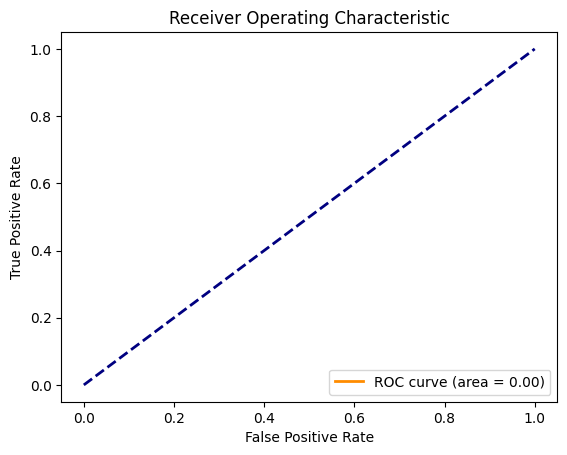

In [ ]:
# Question 2: Generate ROC curve and calculate AUC 
# Compute ROC curve manually
def compute_roc(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    tpr = []
    fpr = []

    for thresh in thresholds:
        y_pred = [1 if score >= thresh else 0 for score in y_scores]
        tp = sum((y_true == 1) & (y_pred == 1))
        fp = sum((y_true == 0) & (y_pred == 1))
        fn = sum((y_true == 1) & (y_pred == 0))
        tn = sum((y_true == 0) & (y_pred == 0))

        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

    return np.array(fpr), np.array(tpr)

# Compute AUC manually
def compute_auc(fpr, tpr):
    return np.trapezoid(tpr, fpr)

# Simulate scores for demonstration
y_scores = np.random.rand(len(y_test))
fpr, tpr = compute_roc(y_test, y_scores)
roc_auc = compute_auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Question 3: Linear regression metrics using normal equations without sklearn
import numpy as np

# Linear Regression using Normal Equations
X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
theta_best = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train

# Predictions
X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_pred_normal_eq = X_test_bias @ theta_best

# Compute regression metrics manually
def mean_absolute_error_manual(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error_manual(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score_manual(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

mae = mean_absolute_error_manual(y_test, y_pred_normal_eq)
mse = mean_squared_error_manual(y_test, y_pred_normal_eq)
r2 = r2_score_manual(y_test, y_pred_normal_eq)
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}")

MAE: 0.18372614473287582, MSE: 0.04731626470228831, R2: 0.9218630491154872
